In [59]:
from web3 import Web3
import os
from dotenv import load_dotenv
import pandas as pd
import prophet
import numpy as np
import datetime as dt
from datetime import timedelta
from prophet import Prophet
from eth_account import Account
from web3.middleware import geth_poa_middleware
from eth_abi import decode
from eth_utils import decode_hex, to_text

import requests
import random
import json

from dune_client.client import DuneClient

import plotly.graph_objs as go

In [2]:
load_dotenv()

ETHERSCAN_KEY = os.getenv("ETHERSCAN_KEY")
COINGECKO_API_KEY = os.getenv("COINGECKO_API_KEY")
DUNE_API_KEY = os.getenv('DUNE_API_KEY')
FLIPSIDE_API_KEY=os.getenv('FLIPSIDE_API_KEY')
dune = DuneClient(DUNE_API_KEY)

GAS_ACCOUNTANT = os.getenv("GAS_ACCOUNTANT")
GAS_RESERVE = os.getenv('GAS_RESERVE')
ACCOUNT_ADDRESS = os.getenv("ACCOUNT_ADDRESS")
PRIVATE_KEY = os.getenv("PRIVATE_KEY")
YIELD_FARM_ADDRESS = os.getenv("YIELD_FARM_ADDRESS")
STAKING_CONTRACT = os.getenv("STAKING_CONTRACT")
SEPOLIA_GATEWAY = os.getenv("SEPOLIA_GATEWAY")

In [3]:
os.chdir('..')

api = False

In [4]:
abi_path = r'gas_accountant_contracts\contracts\artifacts'
abi_paths = []  # Assuming GAS_ACCOUNTANT_ABI_PATH is predefined

for file in os.listdir(abi_path):
    if file.endswith('.json') and "metadata" not in file:  # Exclude metadata files
        abi_paths.append(os.path.join(abi_path, file))  # Add full path

print(abi_paths)  # Debug: Check the final list

abis = {}

for path in abi_paths:
    filename = os.path.basename(path)  # Extract filename (e.g., "YieldVault.json")
    name = os.path.splitext(filename)[0]  # Remove .json extension (e.g., "YieldVault")

    with open(path, "r") as file:
        abis[name] = json.load(file)  # Use name as key

print(abis)  # Debug output

['gas_accountant_contracts\\contracts\\artifacts\\GasReserve.json', 'gas_accountant_contracts\\contracts\\artifacts\\IGasReserve.json', 'gas_accountant_contracts\\contracts\\artifacts\\ILiquidStaking.json', 'gas_accountant_contracts\\contracts\\artifacts\\LiquidStaking.json', 'gas_accountant_contracts\\contracts\\artifacts\\StETHStrategy.json', 'gas_accountant_contracts\\contracts\\artifacts\\TestBTC.json', 'gas_accountant_contracts\\contracts\\artifacts\\TestETH.json', 'gas_accountant_contracts\\contracts\\artifacts\\YieldVault.json']
{'GasReserve': {'deploy': {'VM:-': {'linkReferences': {}, 'autoDeployLib': True}, 'main:1': {'linkReferences': {}, 'autoDeployLib': True}, 'ropsten:3': {'linkReferences': {}, 'autoDeployLib': True}, 'rinkeby:4': {'linkReferences': {}, 'autoDeployLib': True}, 'kovan:42': {'linkReferences': {}, 'autoDeployLib': True}, 'goerli:5': {'linkReferences': {}, 'autoDeployLib': True}, 'Custom': {'linkReferences': {}, 'autoDeployLib': True}}, 'data': {'bytecode': {'

In [5]:
abis.keys()

dict_keys(['GasReserve', 'IGasReserve', 'ILiquidStaking', 'LiquidStaking', 'StETHStrategy', 'TestBTC', 'TestETH', 'YieldVault'])

In [6]:
w3 = Web3(Web3.HTTPProvider(SEPOLIA_GATEWAY))

ACCOUNT = Account.from_key(PRIVATE_KEY)

w3.eth.default_account = ACCOUNT.address
w3.middleware_onion.inject(geth_poa_middleware, layer=0)

In [7]:
def dune_api_results(query_num, save_csv=False, csv_path=None):
    results = dune.get_latest_result(query_num)
    df = pd.DataFrame(results.result.rows)

    if save_csv and csv_path:
        df.to_csv(csv_path, index=False)
    return df

In [8]:
def get_token_price(token='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'):
    url = f"https://api.coingecko.com/api/v3/simple/token_price/ethereum?contract_addresses={token}&vs_currencies=usd"

    headers = {
        "accept": "application/json",
        "x-cg-demo-api-key": COINGECKO_API_KEY
    }

    response = requests.get(url, headers=headers)

    

    eth_data = response.json()

    eth_df = pd.DataFrame(eth_data)
    eth_usd = eth_df[f'{token}'].values[0]

    print(eth_usd)

    return eth_usd

In [9]:
def process_transaction(tx):
    gas_price = float(tx.get("gasPrice", np.nan))  # Allow gasPrice to be NaN
    gas_used = int(tx["gasUsed"])
    
    return {
        "blockNumber": int(tx["blockNumber"]),
        "timestamp": dt.datetime.utcfromtimestamp(int(tx["timeStamp"])),
        "transaction_hash": tx["hash"],
        "from": tx["from"],
        "to": tx["to"] if tx.get("to") else "Contract Deployment",
        "gas": int(tx["gas"]),
        "gasPrice": gas_price,  # Leave NaN if missing
        "gasUsed": gas_used,
        "tx_fee": (gas_used * gas_price / 1e18) if not np.isnan(gas_price) else np.nan,  # Handle NaN in calculation
        "contractAddress": tx.get("contractAddress"),  # Default to None if contractAddress is missing
    }


In [10]:
def get_tx_and_log_with_pagination(contract_address, start_block, end_block, etherscan_api_key,module='account',action='txlist'):
    """
    Fetch logs for a contract address with pagination support from the Etherscan API.

    Parameters:
        contract_address (str): The contract address to fetch logs for.
        start_block (int): The starting block number.
        end_block (int): The ending block number or "latest".
        etherscan_api_key (str): Your Etherscan API key.
        topic_filters (dict, optional): A dictionary of topic filters, e.g.,
            {
                "topic0": "0xe085b50dde9f45e2f6290b8f6eadc05e9f66d77b30d750cb3930c5e3430b9c1e",
                "topic1": "0x0000000000000000000000002102240d1a36a9dc9f3a4d07ee9251cb723aca89",
                "topic2": None,
                "topic3": None,
                "topic0_1_opr": "and"
            }

    Returns:
        list: A list of logs fetched from the API.
    """
    if module == 'account':
        data_pulled = 'tx'
    else:
        data_pulled = 'log'

    base_url = "https://api-sepolia.etherscan.io/api"
    logs = []  # To store all logs
    page = 1
    offset = 1000  # Max records per page

    while True:
        # Construct the base URL
        url = (
            f"{base_url}?module={module}"
            f"&action={action}"
            f"&address={contract_address}"
            f"&fromBlock={start_block}"
            f"&toBlock={end_block}"
            f"&page={page}"
            f"&offset={offset}"
            f"&apikey={etherscan_api_key}"
        )

        try:
            # Make the API request
            response = requests.get(url)
            response.raise_for_status()

            data = response.json()
            if data["status"] != "1":  # Etherscan returns "1" for success
                print(f"No more {data_pulled}s or error: {data.get('message', 'Unknown error')}")
                break

            logs.extend(data["result"])  # Append the logs to the list
            print(f"Fetched {len(data['result'])} {data_pulled}s from page {page}.")

            # Stop if fewer than `offset` logs are returned
            if len(data["result"]) < offset:
                print(f"All {data_pulled}s fetched.")
                break

            page += 1  # Move to the next page

        except requests.RequestException as e:
            print(f"Error while fetching {data_pulled}s: {e}")
            break

    return logs

In [11]:
def parse_gas_log(log):
    """
    Parse a gas request log entry.

    Parameters:
        log (dict): A raw log entry from Etherscan.

    Returns:
        dict: Parsed log data.
    """
    # Extract transaction hash
    tx_hash = log["transactionHash"]

    # Extract requester's address from topic[1]
    requester = "0x" + log["topics"][1][-40:]

    # Decode data fields
    data = log["data"][2:]  # Remove "0x"
    timestamp = int(data[0:64], 16)  # Convert hex to int
    amount = int(data[64:128], 16) / 1e18  # Convert to ETH

    # Convert timestamp to human-readable format
    timestamp_human = dt.datetime.utcfromtimestamp(timestamp)

    return {
        "timestamp": timestamp_human,
        "transaction_hash": tx_hash,
        "requester": requester,
        "gas_amount_eth": amount,
    }


In [12]:
def token_prices(token_addresses, network, start_date):
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    """
    Generate a SQL query to get historical price data for given token addresses from a specific start date.

    Parameters:
    - token_addresses (list): List of token addresses.
    - start_date (str): Start date in 'YYYY-MM-DD' format.

    Returns:
    - str: The SQL query string.
    """
    # Format the addresses into the SQL VALUES clause
    addresses_clause = ", ".join(f"(LOWER('{address}'))" for address in token_addresses)

    beginning = f"'{start_date.strftime('%Y-%m-%d %H:%M:%S')}'"
    print('Beginning:', beginning)
    
    prices_query = f"""
    WITH addresses AS (
        SELECT column1 AS token_address 
        FROM (VALUES
            {addresses_clause}
        ) AS tokens(column1)
    )

    SELECT 
        hour,
        symbol,
        price
    FROM 
        {network}.price.ez_prices_hourly
    WHERE 
        token_address IN (SELECT token_address FROM addresses)
        AND hour >= DATE_TRUNC('hour', TO_TIMESTAMP({beginning}, 'YYYY-MM-DD HH24:MI:SS'))
    ORDER BY 
        hour DESC, symbol
    """

    return prices_query

In [13]:
def flipside_api_results(query, api_key, attempts=10, delay=30):
    """
    Creates and retrieves results for a query using Flipside's JSON-RPC API with pagination.

    Parameters:
    - query: str, the SQL query to execute.
    - api_key: str, your Flipside API key.
    - attempts: int, number of attempts to poll for query completion.
    - delay: int, delay (in seconds) between polling attempts.

    Returns:
    - pd.DataFrame: DataFrame containing the query results.
    """
    import requests
    import time
    import pandas as pd

    # Step 1: Create the query
    url = "https://api-v2.flipsidecrypto.xyz/json-rpc"
    headers = {
        "Content-Type": "application/json",
        "x-api-key": api_key
    }
    payload = {
        "jsonrpc": "2.0",
        "method": "createQueryRun",
        "params": [
            {
                "resultTTLHours": 1,
                "maxAgeMinutes": 0,
                "sql": query,
                "tags": {"source": "python-script", "env": "production"},
                "dataSource": "snowflake-default",
                "dataProvider": "flipside"
            }
        ],
        "id": 1
    }

    response = requests.post(url, headers=headers, json=payload)
    response_data = response.json()

    if 'error' in response_data:
        raise Exception(f"Error creating query: {response_data['error']['message']}")

    query_run_id = response_data.get('result', {}).get('queryRun', {}).get('id')
    if not query_run_id:
        raise KeyError(f"Query creation failed. Response: {response_data}")

    # Step 2: Poll for query completion
    for attempt in range(attempts):
        status_payload = {
            "jsonrpc": "2.0",
            "method": "getQueryRunResults",
            "params": [
                {
                    "queryRunId": query_run_id,
                    "format": "json",
                    "page": {"number": 1, "size": 10000}
                }
            ],
            "id": 1
        }
        response = requests.post(url, headers=headers, json=status_payload)
        resp_json = response.json()

        if 'result' in resp_json and 'rows' in resp_json['result']:
            # Step 3: Handle pagination
            all_rows = []
            page_number = 1

            while True:
                status_payload["params"][0]["page"]["number"] = page_number
                response = requests.post(url, headers=headers, json=status_payload)
                resp_json = response.json()

                if 'result' in resp_json and 'rows' in resp_json['result']:
                    rows = resp_json['result']['rows']
                    if not rows:
                        break  # No more rows to fetch
                    all_rows.extend(rows)
                    page_number += 1
                else:
                    break

            # Convert the rows to a DataFrame
            return pd.DataFrame(all_rows)

        if 'error' in resp_json and 'not yet completed' in resp_json['error'].get('message', '').lower():
            time.sleep(delay)  # Wait before retrying
        else:
            raise Exception(f"Unexpected error while fetching query results: {resp_json}")

    raise TimeoutError(f"Query did not complete after {attempts} attempts.")

In [14]:
def to_time(df):
    time_cols = ['date','dt','hour','time','day','month','year','week','timestamp','date(utc)','block_timestamp']
    for col in df.columns:
        if col.lower() in time_cols and col.lower() != 'timestamp':
            df[col] = pd.to_datetime(df[col])
            df.set_index(col, inplace=True)
        elif col.lower() == 'timestamp':
            df[col] = pd.to_datetime(df[col], unit='ms')
            df.set_index(col, inplace=True)
    print(df.index)
    return df 

def clean_prices(prices_df):
    print('cleaning prices')
    # Pivot the dataframe
    breakpoint()
    prices_df = prices_df.drop_duplicates(subset=['hour', 'symbol'])
    prices_df_pivot = prices_df.pivot(
        index='hour',
        columns='symbol',
        values='price'
    )
    prices_df_pivot = prices_df_pivot.reset_index()

    # Rename the columns by combining 'symbol' with a suffix
    prices_df_pivot.columns = ['dt'] + [f'{col}_price' for col in prices_df_pivot.columns[1:]]
    
    print(f'cleaned prices: {prices_df_pivot}')
    return prices_df_pivot

In [15]:
def data_processing(df,dropna=True):
    df.columns=df.columns.str.lower()
    clean_df = clean_prices(df)
    clean_df = to_time(clean_df)
    if dropna == True:
        clean_df = clean_df.dropna(axis=1, how='any')

    if '__row_index' in clean_df.columns:
        clean_df.drop(columns=['__row_index'], inplace=True)

    return clean_df

# Gas Price Forecasting

In [16]:
def get_sepolia_gas_history(api, term='long_term'):
    lt_sepolia_gas_data_path = 'data/sepolia_gas_metrics.csv'
    st_sepolia_gas_data_path = 'data/current_sepolia_gas_metrics.csv'

    if api:
        if term == 'long_term':
            query = 4622627  # 2 Years worth
            sepolia_gas_data = dune_api_results(query, True, lt_sepolia_gas_data_path)
            sepolia_gas_data.to_csv(lt_sepolia_gas_data_path, index=False)  # ✅ Moved inside block
        
        elif term == 'short_term':
            query = 4650506  # Runs daily at midnight for latest prices
            sepolia_gas_data = dune_api_results(query, True, st_sepolia_gas_data_path)
            sepolia_gas_data.to_csv(st_sepolia_gas_data_path, index=False)

        else:
            print('Pass "long_term" or "short_term" as parameters')
            return None

    else:
        if term == 'long_term':
            sepolia_gas_data = pd.read_csv(lt_sepolia_gas_data_path)
        elif term == 'short_term':
            sepolia_gas_data = pd.read_csv(st_sepolia_gas_data_path)
        else:
            print('Pass "long_term" or "short_term" as parameters')
            return None

    # Convert 'hour' column to datetime format
    sepolia_gas_data['hour'] = pd.to_datetime(sepolia_gas_data['hour'])

    return sepolia_gas_data

In [17]:
long_term_sepolia_gas = get_sepolia_gas_history(False,'long_term')

In [18]:
short_term_sepolia_gas = get_sepolia_gas_history(False,'short_term')

In [19]:
short_term_sepolia_gas

,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price
0,2025-01-31 23:00:00+00:00,100000000000,1.975151e+09,901905452,1.224018e+09,2.485303e+09
1,2025-01-31 22:00:00+00:00,100000000000,2.000216e+09,815791549,1.259035e+09,2.527053e+09
2,2025-01-31 21:00:00+00:00,210000000000,2.858135e+09,1193908859,2.211837e+09,3.439532e+09
3,2025-01-31 20:00:00+00:00,210000000000,3.130228e+09,1858195062,2.491308e+09,3.632018e+09
4,2025-01-31 19:00:00+00:00,500000000000,7.116758e+09,1978633021,4.255715e+09,9.735677e+09
5,2025-01-31 18:00:00+00:00,614806191671,2.222849e+10,9790439166,1.720389e+10,2.915616e+10
6,2025-01-31 17:00:00+00:00,896177980852,1.029691e+10,6083004053,9.014917e+09,1.120849e+10
7,2025-01-31 16:00:00+00:00,1470000000000,1.616902e+10,9397889672,1.299390e+10,2.024024e+10
8,2025-01-31 15:00:00+00:00,1470000000000,8.295084e+09,4879524531,7.261535e+09,9.194055e+09
9,2025-01-31 14:00:00+00:00,892900071902,7.794638e+09,3365698853,6.126430e+09,8.781174e+09


In [20]:
long_term_sepolia_gas

,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price
0,2025-01-30 04:00:00+00:00,100000000000,2.178866e+09,871441221,1.282759e+09,2.536024e+09
1,2025-01-30 03:00:00+00:00,222995523835,2.158460e+09,842989635,1.322712e+09,2.572218e+09
2,2025-01-30 02:00:00+00:00,300000000000,2.281369e+09,827189632,1.325706e+09,2.635527e+09
3,2025-01-30 01:00:00+00:00,200000000000,2.147583e+09,827189632,1.176685e+09,2.532289e+09
4,2025-01-30 00:00:00+00:00,290000000000,2.136518e+09,819280840,1.382348e+09,2.524868e+09
...,...,...,...,...,...,...
17280,2023-02-10 04:00:00+00:00,25000000000000,1.518708e+09,7,1.500000e+09,4.500000e+09
17281,2023-02-10 03:00:00+00:00,25000000000000,5.447670e+09,7,4.946813e+09,1.093770e+10
17282,2023-02-10 02:00:00+00:00,100000000000,4.350000e+09,7,2.776746e+09,5.178040e+09
17283,2023-02-10 01:00:00+00:00,100000000000,2.383351e+09,7,1.548750e+09,4.590795e+09


In [21]:
def set_global_seed(env, seed=20):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


In [50]:
target = 'median_gas_price'
days = 30

target_df = long_term_sepolia_gas.set_index('hour')[[target]]

<Axes: xlabel='hour'>

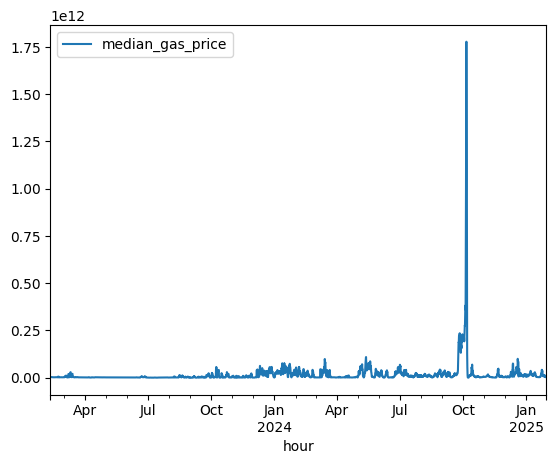

In [51]:
target_df.rolling(window=days).mean().plot()

<Axes: >

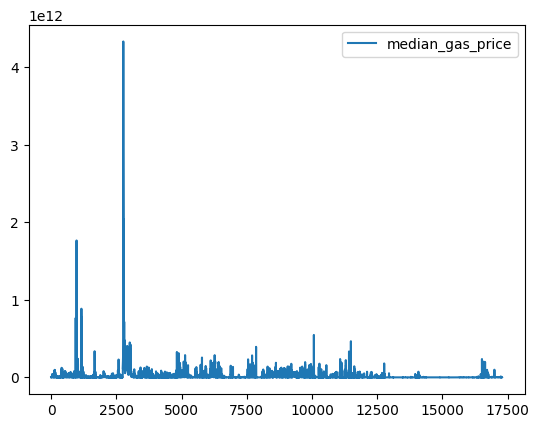

In [53]:
long_term_sepolia_gas[[target]].plot()

In [54]:
target_df.reset_index(inplace=True)
target_df.rename(columns={"hour":"ds","median_gas_price":"y"},inplace=True)

In [55]:
target_df['ds'] = pd.to_datetime(target_df['ds'])
print(target_df.dtypes)


ds    datetime64[ns, UTC]
y                 float64
dtype: object


In [63]:
target_df['ds'] = target_df['ds'].dt.strftime('%Y-%m-%d %H:00:00')


AttributeError: Can only use .dt accessor with datetimelike values

In [64]:
target_df

,ds,y
0,2025-01-30 04:00:00,2.178866e+09
1,2025-01-30 03:00:00,2.158460e+09
2,2025-01-30 02:00:00,2.281369e+09
3,2025-01-30 01:00:00,2.147583e+09
4,2025-01-30 00:00:00,2.136518e+09
...,...,...
17280,2023-02-10 04:00:00,1.518708e+09
17281,2023-02-10 03:00:00,5.447670e+09
17282,2023-02-10 02:00:00,4.350000e+09
17283,2023-02-10 01:00:00,2.383351e+09


In [65]:
target_df.describe()

,y
count,1.728500e+04
mean,1.784330e+10
std,9.409128e+10
min,1.528736e+01
25%,1.267419e+09
50%,1.879485e+09
75%,8.455652e+09
max,4.328198e+12


In [ ]:
target_df['ds'] = pd.to_datetime(target_df['ds'])


,ds,y
0,2025-01-30 04:00:00,2.178866e+09
1,2025-01-30 03:00:00,2.158460e+09
2,2025-01-30 02:00:00,2.281369e+09
3,2025-01-30 01:00:00,2.147583e+09
4,2025-01-30 00:00:00,2.136518e+09
...,...,...
17280,2023-02-10 04:00:00,1.518708e+09
17281,2023-02-10 03:00:00,5.447670e+09
17282,2023-02-10 02:00:00,4.350000e+09
17283,2023-02-10 01:00:00,2.383351e+09


In [74]:
target_df.reset_index()

,ds,y
0,2025-01-30 04:00:00,2.178866e+09
1,2025-01-30 03:00:00,2.158460e+09
2,2025-01-30 02:00:00,2.281369e+09
3,2025-01-30 01:00:00,2.147583e+09
4,2025-01-30 00:00:00,2.136518e+09
...,...,...
17280,2023-02-10 04:00:00,1.518708e+09
17281,2023-02-10 03:00:00,5.447670e+09
17282,2023-02-10 02:00:00,4.350000e+09
17283,2023-02-10 01:00:00,2.383351e+09


In [89]:
import matplotlib.pyplot as plt

2025-01-31 19:46:39,277 DEBUG cmdstanpy cmd: where.exe tbb.dll
cwd: None
2025-01-31 19:46:39,504 DEBUG cmdstanpy TBB already found in load path
2025-01-31 19:46:39,534 INFO prophet Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-01-31 19:46:39,569 DEBUG cmdstanpy input tempfile: C:\Users\BRANDY~1\AppData\Local\Temp\tmp5s_bxmy0\raow6f_v.json
2025-01-31 19:46:40,323 DEBUG cmdstanpy input tempfile: C:\Users\BRANDY~1\AppData\Local\Temp\tmp5s_bxmy0\xuspom8c.json
2025-01-31 19:46:40,326 DEBUG cmdstanpy idx 0
2025-01-31 19:46:40,326 DEBUG cmdstanpy running CmdStan, num_threads: None
2025-01-31 19:46:40,327 DEBUG cmdstanpy CmdStan args: ['E:\\Projects\\steth_optimizer\\steth_optimizer\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=15759', 'data', 'file=C:\\Users\\BRANDY~1\\AppData\\Local\\Temp\\tmp5s_bxmy0\\raow6f_v.json', 'init=C:\\Users\\BRANDY~1\\AppData\\Local\\Temp\\tmp5s_bxmy0\\xuspom8c.json', 'output', 'file=C:

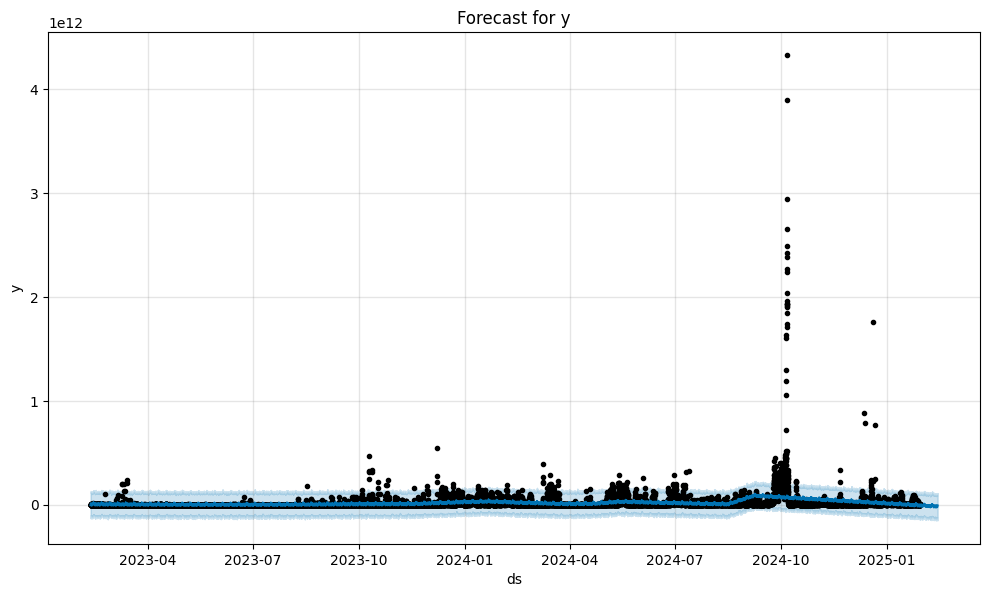

Asset: y
R2: 0.05679872941906661
MAE: 23260166635.84866



In [90]:
def forecast_with_prophet(asset_name, df):
    # Prepare the dataframe for Prophet
    df_prophet = df[['ds', asset_name]].rename(columns={asset_name: 'y'})
    
    # Initialize and fit the model
    model = Prophet()
    model.fit(df_prophet)
    
    # Make a future dataframe for predictions
    future = model.make_future_dataframe(periods=365, freq='H')  # Predicting 365 hours into the future
    forecast = model.predict(future)
    
    # Merge the forecast with actual values
    df_merged = df_prophet.merge(forecast[['ds', 'yhat']], on='ds', how='left')
    
    # Plot the forecast
    fig = model.plot(forecast)
    plt.title(f'Forecast for {asset_name}')
    plt.show()
    
    return df_merged
# Loop through each asset and apply Prophet
results = {}
for asset in ['y']:
    results[asset] = forecast_with_prophet(asset, target_df.reset_index())

for asset, df_merged in results.items():
    # Drop rows with NaN values in 'yhat'
    df_merged = df_merged.dropna(subset=['yhat'])
    
    # Calculate R2
    r2 = r2_score(df_merged['y'], df_merged['yhat'])
    
    # Calculate MAE
    mae = mean_absolute_error(df_merged['y'], df_merged['yhat'])
    
    print(f'Asset: {asset}')
    print(f'R2: {r2}')
    print(f'MAE: {mae}')
    print()

In [96]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from prophet import Prophet

def evaluate_forecast(target_df, train_size=0.75, freq='H'):
    """
    Splits data into a train/test set, trains Prophet, and evaluates the forecast.

    Parameters:
    - target_df: DataFrame containing actual values with columns ['ds', 'y']
    - train_size: Proportion of the dataset to use for training (default: 0.75 for 75% train, 25% test)
    - freq: Frequency of the dataset (default: 'H' for hourly data)

    Returns:
    - A dictionary with evaluation metrics.
    """

    # Sort data by date to avoid any shuffling issues
    target_df = target_df.sort_values('ds')

    # Determine the index where to split based on `train_size`
    split_idx = int(len(target_df) * train_size)

    # Train and test sets
    train_df = target_df.iloc[:split_idx]  # First `train_size`% for training
    test_df = target_df.iloc[split_idx:]   # Remaining for testing

    # Train Prophet model
    m = Prophet()
    m.fit(train_df)

    # Generate future dataframe for forecasting
    future = m.make_future_dataframe(periods=len(test_df), freq=freq)

    # Predict
    forecast = m.predict(future)

    # Merge predictions with actual test values
    merged_df = test_df.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

    # Extract actual and predicted values
    y_true = merged_df['y'].values
    y_pred = merged_df['yhat'].values

    # Calculate evaluation metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error

    # Print results
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return {
        "r2_score": r2,
        "mae": mae,
        "rmse": rmse,
        "mape": mape,
    }


In [103]:
long_term_sepolia_gas

,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price
0,2025-01-30 04:00:00+00:00,100000000000,2.178866e+09,871441221,1.282759e+09,2.536024e+09
1,2025-01-30 03:00:00+00:00,222995523835,2.158460e+09,842989635,1.322712e+09,2.572218e+09
2,2025-01-30 02:00:00+00:00,300000000000,2.281369e+09,827189632,1.325706e+09,2.635527e+09
3,2025-01-30 01:00:00+00:00,200000000000,2.147583e+09,827189632,1.176685e+09,2.532289e+09
4,2025-01-30 00:00:00+00:00,290000000000,2.136518e+09,819280840,1.382348e+09,2.524868e+09
...,...,...,...,...,...,...
17280,2023-02-10 04:00:00+00:00,25000000000000,1.518708e+09,7,1.500000e+09,4.500000e+09
17281,2023-02-10 03:00:00+00:00,25000000000000,5.447670e+09,7,4.946813e+09,1.093770e+10
17282,2023-02-10 02:00:00+00:00,100000000000,4.350000e+09,7,2.776746e+09,5.178040e+09
17283,2023-02-10 01:00:00+00:00,100000000000,2.383351e+09,7,1.548750e+09,4.590795e+09


In [98]:
# results = evaluate_forecast(target_df.reset_index())

2025-01-31 19:49:32,138 DEBUG cmdstanpy cmd: where.exe tbb.dll
cwd: None
2025-01-31 19:49:32,325 DEBUG cmdstanpy TBB already found in load path
2025-01-31 19:49:32,347 INFO prophet Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-01-31 19:49:32,369 DEBUG cmdstanpy input tempfile: C:\Users\BRANDY~1\AppData\Local\Temp\tmp5s_bxmy0\yeugcyhh.json
2025-01-31 19:49:33,155 DEBUG cmdstanpy input tempfile: C:\Users\BRANDY~1\AppData\Local\Temp\tmp5s_bxmy0\qzrowpyb.json
2025-01-31 19:49:33,157 DEBUG cmdstanpy idx 0
2025-01-31 19:49:33,158 DEBUG cmdstanpy running CmdStan, num_threads: None
2025-01-31 19:49:33,159 DEBUG cmdstanpy CmdStan args: ['E:\\Projects\\steth_optimizer\\steth_optimizer\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=21453', 'data', 'file=C:\\Users\\BRANDY~1\\AppData\\Local\\Temp\\tmp5s_bxmy0\\yeugcyhh.json', 'init=C:\\Users\\BRANDY~1\\AppData\\Local\\Temp\\tmp5s_bxmy0\\qzrowpyb.json', 'output', 'file=C:

R² Score: -0.0114
MAE: 40232244761.2071
RMSE: 181606669717.1086
MAPE: 8604.61%


In [104]:
# Load Data
df_gas = long_term_sepolia_gas.copy()

# Rename timestamp column for consistency
df_gas.rename(columns={'hour': 'ds'}, inplace=True)

# Sort by time
df_gas = df_gas.sort_values(by="ds")

# Compute rolling averages
df_gas["median_gas_price_7d"] = df_gas["median_gas_price"].rolling(window=7 * 24, min_periods=1).mean()
df_gas["median_gas_price_30d"] = df_gas["median_gas_price"].rolling(window=30 * 24, min_periods=1).mean()

# Drop NaN values (first few rows may have missing rolling averages)
df_gas.dropna(inplace=True)

# Print to check data structure
print(df_gas.head())

                             ds   max_gas_price  median_gas_price  \
17284 2023-02-10 00:00:00+00:00   1000000000000      3.453234e+09   
17283 2023-02-10 01:00:00+00:00    100000000000      2.383351e+09   
17282 2023-02-10 02:00:00+00:00    100000000000      4.350000e+09   
17281 2023-02-10 03:00:00+00:00  25000000000000      5.447670e+09   
17280 2023-02-10 04:00:00+00:00  25000000000000      1.518708e+09   

       min_gas_price  p25_gas_price  p75_gas_price  median_gas_price_7d  \
17284              7   2.500000e+09   7.500000e+09         3.453234e+09   
17283              7   1.548750e+09   4.590795e+09         2.918293e+09   
17282              7   2.776746e+09   5.178040e+09         3.395528e+09   
17281              7   4.946813e+09   1.093770e+10         3.908564e+09   
17280              7   1.500000e+09   4.500000e+09         3.430593e+09   

       median_gas_price_30d  
17284          3.453234e+09  
17283          2.918293e+09  
17282          3.395528e+09  
17281         

In [113]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def prepare_lstm_multifeature(df, target_col="median_gas_price", seq_length=24):
    """
    Prepares LSTM-ready sequences with multiple regressors.

    Parameters:
    - df: DataFrame with time series and regressors.
    - target_col: Column to predict.
    - seq_length: Time steps to use in input sequences.

    Returns:
    - X (features), y (target), feature scaler, and target scaler.
    """

    # Select feature columns
    feature_cols = ["max_gas_price", "min_gas_price", "p25_gas_price", "p75_gas_price", 
                    "median_gas_price_7d", "median_gas_price_30d"]

    # Normalize features separately
    feature_scaler = MinMaxScaler()
    df_scaled_features = pd.DataFrame(feature_scaler.fit_transform(df[feature_cols]), columns=feature_cols)

    # Normalize target separately
    target_scaler = MinMaxScaler()
    df_scaled_target = pd.DataFrame(target_scaler.fit_transform(df[[target_col]]), columns=[target_col])

    sequences = []
    targets = []

    for i in range(len(df) - seq_length):
        sequences.append(df_scaled_features.values[i:i + seq_length])  # Features
        targets.append(df_scaled_target.values[i + seq_length])  # Target

    X = np.array(sequences)
    y = np.array(targets)

    return X, y, feature_scaler, target_scaler  # Return target_scaler for inverse transform


In [106]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModelMulti(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModelMulti, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Use last time step's output


In [114]:
def train_lstm_multifeature(df, target_col="median_gas_price", seq_length=24, train_ratio=0.75, epochs=50, batch_size=32):
    """
    Trains and evaluates an LSTM model using multiple regressors.

    Parameters:
    - df: DataFrame containing the time series and regressors.
    - target_col: Column to predict.
    - seq_length: Time steps in input sequences.
    - train_ratio: Ratio of dataset used for training.
    - epochs: Number of training epochs.
    - batch_size: Batch size.

    Returns:
    - Dictionary of evaluation metrics.
    """

    # Prepare LSTM data
    X, y, feature_scaler, target_scaler = prepare_lstm_multifeature(df, target_col=target_col, seq_length=seq_length)

    # Split into train and test sets
    split_idx = int(len(X) * train_ratio)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Convert to PyTorch tensors
    X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
    y_train, y_test = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1), torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Define LSTM Model
    input_size = X_train.shape[2]  # Number of features
    model = LSTMModelMulti(input_size=input_size, hidden_size=50, num_layers=2, output_size=1)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        output = model(X_train)
        loss = criterion(output, y_train)

        # Backward pass
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

    # Evaluate Model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze().numpy()
        y_test = y_test.squeeze().numpy()

    # ✅ Use target_scaler for inverse transform (not feature_scaler)
    y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Compute metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Mean Absolute Percentage Error

    # Print results
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return {
        "r2_score": r2,
        "mae": mae,
        "rmse": rmse,
        "mape": mape,
    }


In [ ]:
# # Train Multi-Feature LSTM Model
# results = train_lstm_multifeature(df_gas, target_col="median_gas_price", seq_length=24, epochs=50, batch_size=32)

# # Print Results
# print(results)


e:\Projects\steth_optimizer\steth_optimizer\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([12945, 1, 1])) that is different to the input size (torch.Size([12945, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [0/50], Loss: 0.0013
Epoch [10/50], Loss: 0.0001
Epoch [20/50], Loss: 0.0001
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0000
R² Score: -0.0382
MAE: 38253629440.0000
RMSE: 184118902784.0000
MAPE: 8592.76%
{'r2_score': -0.03823554515838623, 'mae': 38253630000.0, 'rmse': 184118900000.0, 'mape': 8592.758178710938}


In [163]:
from prophet import Prophet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import joblib

def evaluate_prophet_with_regressors(df, regressors, train_size=0.75, freq='H',model_path='prophet_model.pkl',save=False):
    """
    Trains a Prophet model with multiple regressors and evaluates its forecast.

    Parameters:
    - df: DataFrame with ['ds', 'y'] (target variable) and regressors.
    - regressors: List of column names to use as extra regressors.
    - train_size: Proportion of the dataset to use for training (default: 0.75).
    - freq: Frequency of the dataset ('H' for hourly).

    Returns:
    - Dictionary with evaluation metrics.
    """

    # Ensure correct column names
    df = df.rename(columns={'hour': 'ds', 'median_gas_price': 'y'})

    # Sort data by timestamp
    df = df.sort_values('ds')

    # Verify all regressors exist
    missing_cols = [col for col in regressors if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing regressors in dataframe: {missing_cols}")

    # Split train/test data
    split_idx = int(len(df) * train_size)
    train_df = df.iloc[:split_idx].copy()  # Training data
    test_df = df.iloc[split_idx:].copy()   # Testing data

    # Initialize Prophet model
    m = Prophet()

    # Add regressors to Prophet
    for reg in regressors:
        m.add_regressor(reg)

    # Fit model with training data
    m.fit(train_df)

    # Save model using joblib
    if save:
        joblib.dump(m, model_path)
        print(f"✅ Model saved at: {model_path}")

    # Create future dataframe
    future = m.make_future_dataframe(periods=len(test_df), freq=freq)

    # ✅ Fix: Assign correct-sized regressors to the future dataframe
    for reg in regressors:
        if reg in df.columns:
            future[reg] = df[reg].iloc[-len(future):].values
        else:
            future[reg] = 0  # Default to zero if missing

    # Predict
    forecast = m.predict(future)

    # Merge predictions with actual test values
    merged_df = test_df.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

    fig = m.plot(forecast)
    plt.title(f'Forecast for {target}')
    plt.show()

    # Extract actual and predicted values
    y_true = merged_df['y'].values
    y_pred = merged_df['yhat'].values

    # Calculate evaluation metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error

    # Print results
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return {
        "r2_score": r2,
        "mae": mae,
        "rmse": rmse,
        "mape": mape,
    }, merged_df


In [164]:
df_gas.rename(columns={target:'y'},inplace=True)

In [165]:
df_gas['ds'] = pd.to_datetime(df_gas['ds']).dt.strftime('%Y-%m-%d %H:00:00')

In [166]:
df_gas['ds'] = pd.to_datetime(df_gas['ds'])
df_gas

,ds,max_gas_price,y,min_gas_price,p25_gas_price,p75_gas_price,median_gas_price_7d,median_gas_price_30d
17284,2023-02-10 00:00:00,1000000000000,3.453234e+09,7,2.500000e+09,7.500000e+09,3.453234e+09,3.453234e+09
17283,2023-02-10 01:00:00,100000000000,2.383351e+09,7,1.548750e+09,4.590795e+09,2.918293e+09,2.918293e+09
17282,2023-02-10 02:00:00,100000000000,4.350000e+09,7,2.776746e+09,5.178040e+09,3.395528e+09,3.395528e+09
17281,2023-02-10 03:00:00,25000000000000,5.447670e+09,7,4.946813e+09,1.093770e+10,3.908564e+09,3.908564e+09
17280,2023-02-10 04:00:00,25000000000000,1.518708e+09,7,1.500000e+09,4.500000e+09,3.430593e+09,3.430593e+09
...,...,...,...,...,...,...,...,...
4,2025-01-30 00:00:00,290000000000,2.136518e+09,819280840,1.382348e+09,2.524868e+09,1.562323e+10,1.308157e+10
3,2025-01-30 01:00:00,200000000000,2.147583e+09,827189632,1.176685e+09,2.532289e+09,1.562312e+10,1.307315e+10
2,2025-01-30 02:00:00,300000000000,2.281369e+09,827189632,1.325706e+09,2.635527e+09,1.562337e+10,1.305386e+10
1,2025-01-30 03:00:00,222995523835,2.158460e+09,842989635,1.322712e+09,2.572218e+09,1.562176e+10,1.300820e+10


2025-01-31 21:16:14,828 DEBUG cmdstanpy cmd: where.exe tbb.dll
cwd: None
2025-01-31 21:16:15,085 DEBUG cmdstanpy TBB already found in load path
2025-01-31 21:16:15,135 INFO prophet Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-01-31 21:16:15,170 DEBUG cmdstanpy input tempfile: C:\Users\BRANDY~1\AppData\Local\Temp\tmp5s_bxmy0\2py0f9nv.json
2025-01-31 21:16:16,122 DEBUG cmdstanpy input tempfile: C:\Users\BRANDY~1\AppData\Local\Temp\tmp5s_bxmy0\zy0xyuym.json
2025-01-31 21:16:16,126 DEBUG cmdstanpy idx 0
2025-01-31 21:16:16,127 DEBUG cmdstanpy running CmdStan, num_threads: None
2025-01-31 21:16:16,128 DEBUG cmdstanpy CmdStan args: ['E:\\Projects\\steth_optimizer\\steth_optimizer\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=4414', 'data', 'file=C:\\Users\\BRANDY~1\\AppData\\Local\\Temp\\tmp5s_bxmy0\\2py0f9nv.json', 'init=C:\\Users\\BRANDY~1\\AppData\\Local\\Temp\\tmp5s_bxmy0\\zy0xyuym.json', 'output', 'file=C:\

✅ Model saved at: E:\Projects\gas_accountant\AI\prophet_model.pkl


e:\Projects\steth_optimizer\steth_optimizer\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\Projects\steth_optimizer\steth_optimizer\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


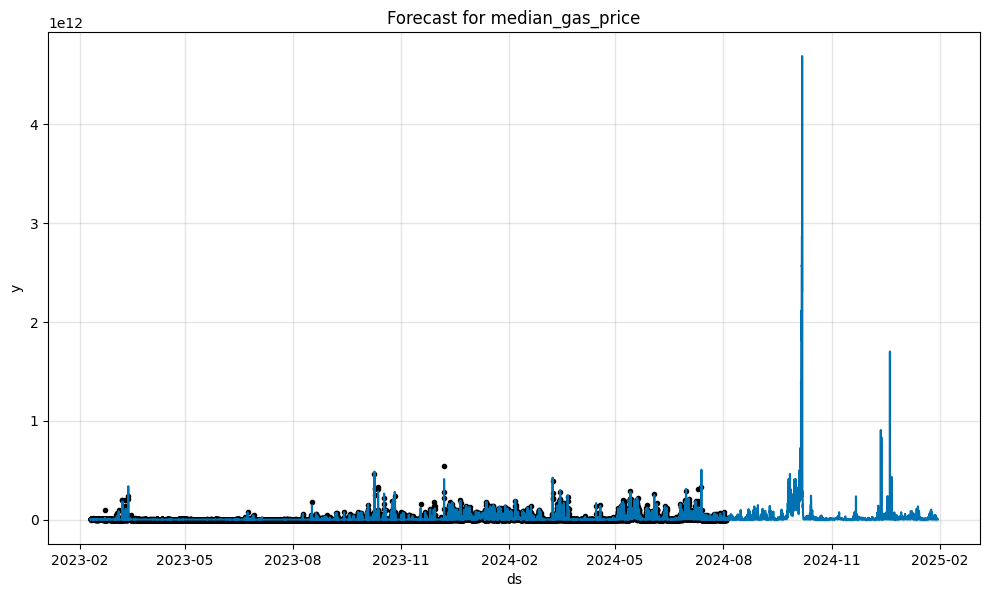

R² Score: 0.9963
MAE: 2871427399.1066
RMSE: 10937635355.0313
MAPE: 1539.35%
{'r2_score': 0.9963311824568777, 'mae': 2871427399.1065865, 'rmse': 10937635355.031315, 'mape': 1539.3470924405203}


In [169]:
# Define regressors to use
regressor_columns = ["max_gas_price", "min_gas_price", "p25_gas_price", "p75_gas_price", 
                     "median_gas_price_7d", "median_gas_price_30d"]

# Train and evaluate Prophet with regressors
results,results_df = evaluate_prophet_with_regressors(df_gas, regressor_columns, train_size=0.75, freq='H',model_path=r'E:\Projects\gas_accountant\AI\prophet_model.pkl',save=True)

# Print results
print(results)


In [170]:
results_df

,ds,max_gas_price,y,min_gas_price,p25_gas_price,p75_gas_price,median_gas_price_7d,median_gas_price_30d,yhat
0,2024-08-03 03:00:00,224146763824,5.345974e+09,1690232763,4.074702e+09,6.818261e+09,8.206674e+09,1.377038e+10,5.929562e+09
1,2024-08-03 04:00:00,186236351238,3.580461e+09,896727767,2.745638e+09,5.220618e+09,8.200050e+09,1.376605e+10,4.536922e+09
2,2024-08-03 05:00:00,183640211005,1.678586e+09,146319268,1.191127e+09,2.117907e+09,8.188892e+09,1.375863e+10,2.564314e+09
3,2024-08-03 06:00:00,186992418500,4.756002e+09,1352996730,3.967257e+09,5.375820e+09,8.155761e+09,1.374477e+10,6.057491e+09
4,2024-08-03 07:00:00,300000000000,2.715013e+09,875445569,2.217463e+09,3.810336e+09,8.115086e+09,1.372824e+10,3.771257e+09
...,...,...,...,...,...,...,...,...,...
4317,2025-01-30 00:00:00,290000000000,2.136518e+09,819280840,1.382348e+09,2.524868e+09,1.562323e+10,1.308157e+10,3.973921e+09
4318,2025-01-30 01:00:00,200000000000,2.147583e+09,827189632,1.176685e+09,2.532289e+09,1.562312e+10,1.307315e+10,3.626378e+09
4319,2025-01-30 02:00:00,300000000000,2.281369e+09,827189632,1.325706e+09,2.635527e+09,1.562337e+10,1.305386e+10,3.797195e+09
4320,2025-01-30 03:00:00,222995523835,2.158460e+09,842989635,1.322712e+09,2.572218e+09,1.562176e+10,1.300820e+10,3.887588e+09


In [99]:
# from itertools import product
# from prophet import Prophet
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# def tune_prophet_hyperparameters(target_df, train_size=0.75, forecast_horizon=24, freq="H"):
#     """
#     Tunes Prophet's seasonality hyperparameters using a 75/25 train-test split.

#     Parameters:
#     - target_df: DataFrame containing ['ds', 'y'] columns.
#     - train_size: Proportion of data to use for training (default: 0.75).
#     - forecast_horizon: Number of future periods to forecast (default: 24).
#     - freq: Frequency of the dataset (default: 'H' for hourly data).

#     Returns:
#     - A dictionary with the best model, best parameters, and evaluation metrics.
#     """

#     # Sort data by date
#     target_df = target_df.sort_values("ds")

#     # Split into train (75%) and test (25%) based on `train_size`
#     split_idx = int(len(target_df) * train_size)
#     train_df = target_df.iloc[:split_idx]
#     test_df = target_df.iloc[split_idx:]

#     # Define parameter grid
#     param_grid = {
#         "yearly_seasonality": [True, False],
#         "weekly_seasonality": [True, False],
#         "daily_seasonality": [True, False],
#         "seasonality_mode": ["additive", "multiplicative"]
#     }

#     # Generate all possible parameter combinations
#     param_combinations = list(product(*param_grid.values()))

#     # Initialize best model tracking
#     best_mape = float("inf")
#     best_params = None
#     best_model = None
#     best_metrics = {}

#     for params in param_combinations:
#         try:
#             # Initialize Prophet model with given parameters
#             model = Prophet(
#                 yearly_seasonality=params[0],
#                 weekly_seasonality=params[1],
#                 daily_seasonality=params[2],
#                 seasonality_mode=params[3]
#             )
#             model.fit(train_df)  # Fit on training data

#             # Create future dataframe for the test period
#             future = model.make_future_dataframe(periods=len(test_df), freq=freq)
#             forecast = model.predict(future)

#             # Merge forecast with actual test values
#             merged_df = test_df.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

#             # Extract actual and predicted values
#             y_true = merged_df['y'].values
#             y_pred = merged_df['yhat'].values

#             # Compute evaluation metrics
#             r2 = r2_score(y_true, y_pred)
#             mae = mean_absolute_error(y_true, y_pred)
#             rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#             mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error

#             # Save best model if MAPE is lower
#             if mape < best_mape:
#                 best_mape = mape
#                 best_params = params
#                 best_model = model
#                 best_metrics = {"r2": r2, "mae": mae, "rmse": rmse, "mape": mape}

#         except Exception as e:
#             print(f"Error with parameters {params}: {e}")

#     # Print best parameters
#     print("Best Parameters:", dict(zip(param_grid.keys(), best_params)))
#     print(f"Best MAPE: {best_mape:.2f}%")
#     print(f"Best R² Score: {best_metrics['r2']:.4f}")
#     print(f"Best RMSE: {best_metrics['rmse']:.4f}")
#     print(f"Best MAE: {best_metrics['mae']:.4f}")

#     return {
#         "best_model": best_model,
#         "best_params": dict(zip(param_grid.keys(), best_params)),
#         "metrics": best_metrics
#     }


In [100]:
# best_result = tune_prophet_hyperparameters(target_df.reset_index())


2025-01-31 19:51:31,642 DEBUG cmdstanpy cmd: where.exe tbb.dll
cwd: None
2025-01-31 19:51:31,893 DEBUG cmdstanpy TBB already found in load path
2025-01-31 19:51:31,958 DEBUG cmdstanpy input tempfile: C:\Users\BRANDY~1\AppData\Local\Temp\tmp5s_bxmy0\d4xj2zod.json
2025-01-31 19:51:33,475 DEBUG cmdstanpy input tempfile: C:\Users\BRANDY~1\AppData\Local\Temp\tmp5s_bxmy0\we3mtwrk.json
2025-01-31 19:51:33,480 DEBUG cmdstanpy idx 0
2025-01-31 19:51:33,481 DEBUG cmdstanpy running CmdStan, num_threads: None
2025-01-31 19:51:33,482 DEBUG cmdstanpy CmdStan args: ['E:\\Projects\\steth_optimizer\\steth_optimizer\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=81872', 'data', 'file=C:\\Users\\BRANDY~1\\AppData\\Local\\Temp\\tmp5s_bxmy0\\d4xj2zod.json', 'init=C:\\Users\\BRANDY~1\\AppData\\Local\\Temp\\tmp5s_bxmy0\\we3mtwrk.json', 'output', 'file=C:\\Users\\BRANDY~1\\AppData\\Local\\Temp\\tmp5s_bxmy0\\prophet_model69v25sgv\\prophet_model-20250131195133.csv', 'method=optimi

Best Parameters: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_mode': 'additive'}
Best MAPE: 3516.95%
Best R² Score: -0.0201
Best RMSE: 182380496296.6054
Best MAE: 36787274938.6286


In [77]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def create_chart(df, columns, title, y2_col=None, tickprefix=dict(y1=None, y2=None), ticksuffix=dict(y1=None, y2=None),show_legend=False,auto_title=True,show=True,save_directory=None):
    # Create a subplot with a secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Define the color cycle
    colors = ['blue', 'red', None]  # Blue, red, then default Plotly colors
    color_index = 0  # To track the current color in the cycle

    for col in columns:
        line_color = colors[color_index]  # Get the current color from the cycle
        color_index = (color_index + 1) % len(colors)  # Update to the next color, cycling back

        if col != y2_col:
            # Add traces to primary y-axis
            fig.add_trace(
                go.Scatter(
                    x=df.index,
                    y=df[col],
                    name=col.replace("_"," ").upper(),
                    line=dict(color=line_color) if line_color else {},
                    showlegend=show_legend
                ),
                secondary_y=False,  # Plot on primary y-axis
            )
        else:
            # Add traces to secondary y-axis
            fig.add_trace(
                go.Scatter(
                    x=df.index,
                    y=df[y2_col],
                    name=y2_col.replace("_"," ").upper(),
                    line=dict(color=line_color) if line_color else {},
                    showlegend=show_legend
                ),
                secondary_y=True,  # Plot on secondary y-axis
            )

    # Update the layout with titles
    fig.update_layout(
        title=title,
        xaxis_title="Date",
        legend=dict(x=0.01, y=0.99),
        template='plotly_white',
        hovermode='x unified',
        font=dict(color='black')
    )

    if auto_title:
        y1_title_text = columns[0].replace("_"," ").upper()
        y2_title_text = y2_col.replace("_"," ").upper() if y2_col else None
    else:
        y1_title_text = None
        y2_title_text = None

    # Set y-axes titles and colors
    fig.update_yaxes(title_text=y1_title_text, secondary_y=False, color='blue', tickprefix=tickprefix['y1'], ticksuffix=ticksuffix['y1'])
    fig.update_yaxes(title_text=y2_title_text, secondary_y=True, color='red', tickprefix=tickprefix['y2'], ticksuffix=ticksuffix['y2'])
    fig.update_xaxes(tickfont=dict(color='black'))

    # Show the plot
    if show:
        fig.show()

    return fig

In [175]:
y_fig = create_chart(results_df.set_index('ds'),['y','yhat'],title='Actual vs Predicted',auto_title=False,show_legend=True)

In [171]:
results_df.columns

Index(['ds', 'max_gas_price', 'y', 'min_gas_price', 'p25_gas_price',
       'p75_gas_price', 'median_gas_price_7d', 'median_gas_price_30d', 'yhat'],
      dtype='object')

In [176]:
model_path = r'E:\Projects\gas_accountant\AI\prophet_model.pkl'

In [177]:
prophet_model = joblib.load(model_path)
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [178]:
import os

def update_prophet_model(df, model_path=r'E:\Projects\gas_accountant\AI\prophet_model.pkl', update_threshold=24):
    """
    Loads an existing Prophet model, updates it if new data is available, and saves it.

    - update_threshold: Minimum number of new hours before refitting.
    """
    if os.path.exists(model_path):
        prophet_model = joblib.load(model_path)
        last_train_ds = prophet_model.history['ds'].max()
    else:
        prophet_model = Prophet()
        last_train_ds = None

    # Check if enough new data is available
    new_data = df[df['ds'] > last_train_ds] if last_train_ds else df

    if len(new_data) >= update_threshold:
        print(f"🔄 Retraining model with {len(new_data)} new data points...")
        prophet_model.fit(df)  # Retrain with updated data
        joblib.dump(prophet_model, model_path)
        print("✅ Model updated and saved!")
    else:
        print("✅ Using existing model (No significant new data).")

    return prophet_model


In [246]:
import pandas as pd
import numpy as np
from prophet import Prophet

def forecast_gas_prices(model, df, regressors, start_date, train_hours=24, forecast_hours=24):
    """
    Uses an existing Prophet model trained on the last `train_hours` of data
    and forecasts `forecast_hours + any missing hours`, starting from the last data timestamp.

    Parameters:
    - model: A fitted Prophet model.
    - df: DataFrame containing historical gas price data.
    - regressors: List of additional columns to use as extra regressors.
    - train_hours: Number of hours to use for training (default: 24).
    - forecast_hours: Number of hours to forecast (default: 24).

    Returns:
    - Forecast DataFrame with predicted hourly gas prices.
    """

    # Ensure correct column names
    df = df.rename(columns={'hour': 'ds', 'median_gas_price': 'y'})

    # Sort data by timestamp
    df = df.sort_values('ds')

    # Get the last timestamp in the dataset
    last_timestamp = df['ds'].max()

    # Get current UTC time rounded to the nearest hour
    now_utc = pd.to_datetime(start_date)

    # Calculate the gap between now and the last data point
    time_gap = (now_utc - last_timestamp).total_seconds() / 3600  # Convert to hours

    # Adjust forecast hours to account for the missing gap
    adjusted_forecast_hours = forecast_hours + int(time_gap)

    print(f"📌 Last data point: {last_timestamp}")
    print(f"📌 Time gap to now: {time_gap:.1f} hours")
    print(f"📌 Forecasting {adjusted_forecast_hours} hours from {last_timestamp}")

    # Create future dataframe starting **right after the last data point**
    future_dates = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), 
                                 periods=adjusted_forecast_hours, freq='H')

    future = pd.DataFrame({'ds': future_dates})

    # ✅ Assign regressor values for future periods
    for reg in regressors:
        if reg in df.columns:
            # Use the last known regressor value
            future[reg] = df[reg].iloc[-1]

    # Predict
    forecast = model.predict(future)

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


In [226]:
short_term_sepolia_gas['hour'].max()

'2025-01-31 23:00:00'

In [227]:
data_start_date = dt.datetime.now(dt.timezone.utc) - timedelta(hours=5)
data_start_date = data_start_date.strftime('%Y-%m-%d %H:00:00')

today_utc = dt.datetime.now(dt.timezone.utc) 
formatted_today_utc = today_utc.strftime('%Y-%m-%d %H:00:00')

In [228]:
(pd.to_datetime(formatted_today_utc) - pd.to_datetime(short_term_sepolia_gas['hour'].max()))

Timedelta('0 days 03:00:00')

In [229]:
pd.to_datetime(short_term_sepolia_gas['hour'].max())

Timestamp('2025-01-31 23:00:00')

In [238]:
forecast_sepolia = short_term_sepolia_gas.copy()

forecast_sepolia = forecast_sepolia.sort_values(by="hour")

# Compute rolling averages
forecast_sepolia["median_gas_price_7d"] = forecast_sepolia["median_gas_price"].rolling(window=7 * 24, min_periods=1).mean()
forecast_sepolia["median_gas_price_30d"] = forecast_sepolia["median_gas_price"].rolling(window=30 * 24, min_periods=1).mean()

# Drop NaN values (first few rows may have missing rolling averages)
forecast_sepolia.dropna(inplace=True)

forecast_sepolia= forecast_sepolia.rename(columns={"hour":"ds","median_gas_price":"y"}).copy()

# Print to check data structure
print(forecast_sepolia.head())

                     ds  max_gas_price             y  min_gas_price  \
47  2025-01-30 00:00:00   290000000000  2.164065e+09      819280840   
46  2025-01-30 01:00:00   200000000000  2.164853e+09      827189632   
45  2025-01-30 02:00:00   300000000000  2.287925e+09      827189632   
44  2025-01-30 03:00:00   222995523835  2.137267e+09      842989635   
43  2025-01-30 04:00:00   300000000000  2.400947e+09      842989635   

    p25_gas_price  p75_gas_price  median_gas_price_7d  median_gas_price_30d  
47   1.280997e+09   2.526772e+09         2.164065e+09          2.164065e+09  
46   1.169588e+09   2.540330e+09         2.164459e+09          2.164459e+09  
45   1.303006e+09   2.633324e+09         2.205614e+09          2.205614e+09  
44   1.319416e+09   2.578880e+09         2.188528e+09          2.188528e+09  
43   1.428753e+09   2.685227e+09         2.231012e+09          2.231012e+09  


In [239]:
forecast_sepolia['ds'] = pd.to_datetime(forecast_sepolia['ds'])

In [ ]:
(pd.to_datetime(formatted_today_utc) - pd.to_datetime(short_term_sepolia_gas['hour'].max()))

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'Timedelta'

In [249]:
# Define regressors
regressor_columns = ["max_gas_price", "min_gas_price", "p25_gas_price", "p75_gas_price",
                     "median_gas_price_7d", "median_gas_price_30d"]

# ✅ Load or update the Prophet model
# model = update_prophet_model(forecast_sepolia, model_path=model_path, update_threshold=24)

# ✅ Forecast the next 24 hours, ensuring it starts from the **current hour**
forecast = forecast_gas_prices(prophet_model, forecast_sepolia,regressor_columns, start_date=formatted_today_utc, train_hours=24, forecast_hours=24)

# ✅ Display the forecast
# import matplotlib.pyplot as plt
# fig = prophet_model.plot(forecast)
# plt.title("Gas Price Forecast Up to the Current Hour")
# plt.show()

📌 Last data point: 2025-01-31 23:00:00
📌 Time gap to now: 3.0 hours
📌 Forecasting 27 hours from 2025-01-31 23:00:00


C:\Users\brandyns pc\AppData\Local\Temp\ipykernel_14048\64528320.py:44: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [253]:
y_fig = create_chart(forecast.set_index('ds'),['yhat'],title=f"Predicted Gas Prices <br> Through {future['ds'].max()}",auto_title=False,show_legend=True)

In [248]:
forecast

,ds,yhat,yhat_lower,yhat_upper
0,2025-02-01 00:00:00,3.155848e+09,-3.935830e+09,9.686525e+09
1,2025-02-01 01:00:00,3.069880e+09,-3.440606e+09,9.818840e+09
2,2025-02-01 02:00:00,3.049649e+09,-3.993545e+09,9.811924e+09
3,2025-02-01 03:00:00,3.169427e+09,-3.646160e+09,9.999729e+09
4,2025-02-01 04:00:00,3.370406e+09,-3.610723e+09,1.054844e+10
5,2025-02-01 05:00:00,3.516379e+09,-2.924426e+09,1.062685e+10
6,2025-02-01 06:00:00,3.528907e+09,-3.486882e+09,9.867634e+09
7,2025-02-01 07:00:00,3.465126e+09,-3.893870e+09,9.754843e+09
8,2025-02-01 08:00:00,3.457907e+09,-3.222982e+09,1.049234e+10
9,2025-02-01 09:00:00,3.576623e+09,-3.198396e+09,1.071441e+10


# Tracking the Test Protocol Gas Reverse

In [22]:
current_block = w3.eth.block_number
print(f"Current block number: {current_block}")

Current block number: 7613720


In [23]:
GAS_RESERVE

'0x0064c627A55AEF07f4aB6Fea62E516A76E38aC8A'

## We can track internal TX of gas reserve contract to see how much it spends

In [24]:
# tx_history = get_tx_with_pagination(GAS_RESERVE, current_block - 10000, current_block - 1, ETHERSCAN_KEY)
internal_tx_history = get_tx_and_log_with_pagination(GAS_RESERVE, current_block - 10000, current_block, ETHERSCAN_KEY, action='txlistinternal')


Fetched 1 txs from page 1.
All txs fetched.


In [25]:
processed_transactions = [process_transaction(tx) for tx in internal_tx_history]

# Convert to DataFrame
df = pd.DataFrame(processed_transactions)

dataset = df.copy()
dataset = dataset[dataset['from']==GAS_RESERVE.lower()]
dataset['hour'] = dataset['timestamp'].dt.strftime('%Y-%m-%d %H:00:00')

### Here we combine gas history to get full tx history

In [29]:
earliest_date = dataset['hour'].min()

In [30]:
eth_query = token_prices(['0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'],'ethereum',earliest_date)
eth_df = flipside_api_results(api_key=FLIPSIDE_API_KEY,query=eth_query)
eth_df['hour'] = pd.to_datetime(eth_df['hour']).dt.strftime('%Y-%m-%d %H:00:00')
eth_df.set_index('hour',inplace=True)
eth_df_wide = data_processing(eth_df.reset_index())
eth_df_wide.index = eth_df_wide.index.strftime('%Y-%m-%d %H:00:00')

Beginning: '2025-01-31 21:00:00'
cleaning prices
cleaned prices:                     dt  WETH_price
0  2025-01-31 21:00:00     3322.87
1  2025-01-31 22:00:00     3327.19
2  2025-01-31 23:00:00     3309.11
3  2025-02-01 00:00:00     3296.75
DatetimeIndex(['2025-01-31 21:00:00', '2025-01-31 22:00:00',
               '2025-01-31 23:00:00', '2025-02-01 00:00:00'],
              dtype='datetime64[ns]', name='dt', freq=None)


In [31]:
short_term_sepolia_gas

,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price
0,2025-01-31 23:00:00+00:00,100000000000,1.975151e+09,901905452,1.224018e+09,2.485303e+09
1,2025-01-31 22:00:00+00:00,100000000000,2.000216e+09,815791549,1.259035e+09,2.527053e+09
2,2025-01-31 21:00:00+00:00,210000000000,2.858135e+09,1193908859,2.211837e+09,3.439532e+09
3,2025-01-31 20:00:00+00:00,210000000000,3.130228e+09,1858195062,2.491308e+09,3.632018e+09
4,2025-01-31 19:00:00+00:00,500000000000,7.116758e+09,1978633021,4.255715e+09,9.735677e+09
5,2025-01-31 18:00:00+00:00,614806191671,2.222849e+10,9790439166,1.720389e+10,2.915616e+10
6,2025-01-31 17:00:00+00:00,896177980852,1.029691e+10,6083004053,9.014917e+09,1.120849e+10
7,2025-01-31 16:00:00+00:00,1470000000000,1.616902e+10,9397889672,1.299390e+10,2.024024e+10
8,2025-01-31 15:00:00+00:00,1470000000000,8.295084e+09,4879524531,7.261535e+09,9.194055e+09
9,2025-01-31 14:00:00+00:00,892900071902,7.794638e+09,3365698853,6.126430e+09,8.781174e+09


In [32]:
dataset

,blockNumber,timestamp,transaction_hash,from,to,gas,gasPrice,gasUsed,tx_fee,contractAddress,hour
0,7612904,2025-01-31 21:28:24,0xaf8ab04470639668568878222952df0a4a44bc10cb6e...,0x0064c627a55aef07f4ab6fea62e516a76e38ac8a,0x0448d01970801692c22ff2eccc570f2f7cd9b889,2300,NaN,55,NaN,,2025-01-31 21:00:00


In [33]:
short_term_sepolia_gas['hour'] = pd.to_datetime(short_term_sepolia_gas['hour']).dt.strftime('%Y-%m-%d %H:00:00')
dataset_merged = dataset.merge(
    short_term_sepolia_gas,
    on='hour',
    how='left'
)
print(dataset)

   blockNumber           timestamp  \
0      7612904 2025-01-31 21:28:24   

                                    transaction_hash  \
0  0xaf8ab04470639668568878222952df0a4a44bc10cb6e...   

                                         from  \
0  0x0064c627a55aef07f4ab6fea62e516a76e38ac8a   

                                           to   gas  gasPrice  gasUsed  \
0  0x0448d01970801692c22ff2eccc570f2f7cd9b889  2300       NaN       55   

   tx_fee contractAddress                 hour  
0     NaN                  2025-01-31 21:00:00  


In [34]:
dataset_merged['hour']

0    2025-01-31 21:00:00
Name: hour, dtype: object

In [35]:
dataset_merged['gasPrice'] = dataset_merged['gasPrice'].fillna(dataset_merged['median_gas_price'])
dataset_merged['tx_fee'] = dataset_merged['tx_fee'].fillna((dataset_merged['gasPrice'] * dataset_merged['gasUsed']) / 1e18)

In [36]:
eth_df_wide.reset_index(inplace=True)
eth_df_wide.rename(columns={'dt':'hour'},inplace=True)

In [37]:
dataset_merged

,blockNumber,timestamp,transaction_hash,from,to,gas,gasPrice,gasUsed,tx_fee,contractAddress,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price
0,7612904,2025-01-31 21:28:24,0xaf8ab04470639668568878222952df0a4a44bc10cb6e...,0x0064c627a55aef07f4ab6fea62e516a76e38ac8a,0x0448d01970801692c22ff2eccc570f2f7cd9b889,2300,2.858135e+09,55,1.571974e-07,,2025-01-31 21:00:00,210000000000,2.858135e+09,1193908859,2.211837e+09,3.439532e+09


In [38]:
eth_df_wide.columns

Index(['hour', 'WETH_price'], dtype='object')

In [39]:
dataset

,blockNumber,timestamp,transaction_hash,from,to,gas,gasPrice,gasUsed,tx_fee,contractAddress,hour
0,7612904,2025-01-31 21:28:24,0xaf8ab04470639668568878222952df0a4a44bc10cb6e...,0x0064c627a55aef07f4ab6fea62e516a76e38ac8a,0x0448d01970801692c22ff2eccc570f2f7cd9b889,2300,NaN,55,NaN,,2025-01-31 21:00:00


In [ ]:
dataset_merged=dataset_merged.merge(
    eth_df_wide,
    on='hour',
    how='left'
)

In [41]:
dataset_merged['tx_fee_usd'] = dataset_merged['tx_fee'] * dataset_merged['WETH_price']
dataset_merged['tx_fee_usd']

0    0.000522
Name: tx_fee_usd, dtype: float64

In [42]:
dataset_merged

,blockNumber,timestamp,transaction_hash,from,to,gas,gasPrice,gasUsed,tx_fee,contractAddress,hour,max_gas_price,median_gas_price,min_gas_price,p25_gas_price,p75_gas_price,WETH_price,tx_fee_usd
0,7612904,2025-01-31 21:28:24,0xaf8ab04470639668568878222952df0a4a44bc10cb6e...,0x0064c627a55aef07f4ab6fea62e516a76e38ac8a,0x0448d01970801692c22ff2eccc570f2f7cd9b889,2300,2.858135e+09,55,1.571974e-07,,2025-01-31 21:00:00,210000000000,2.858135e+09,1193908859,2.211837e+09,3.439532e+09,3322.87,0.000522


## We can also read the event logs to see gas requested, requester, and time requested

In [43]:
logs = get_tx_and_log_with_pagination(GAS_RESERVE, current_block - 10000, current_block, ETHERSCAN_KEY,module='logs', action='getLogs')

Fetched 1 logs from page 1.
All logs fetched.


In [44]:
parsed_logs = [parse_gas_log(log) for log in logs]
for log in parsed_logs:
    print(log)

{'timestamp': datetime.datetime(2025, 1, 31, 21, 28, 24), 'transaction_hash': '0xaf8ab04470639668568878222952df0a4a44bc10cb6e98d911a2c45bba85faea', 'requester': '0x0448d01970801692c22ff2eccc570f2f7cd9b889', 'gas_amount_eth': 0.01}


In [45]:
df = pd.DataFrame(parsed_logs)

# Convert timestamp to datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Set timestamp as the index
df.set_index("timestamp", inplace=True)

# Sort by timestamp
df = df.sort_index()

# Display the first few rows
print(df.head())

                                                      transaction_hash  \
timestamp                                                                
2025-01-31 21:28:24  0xaf8ab04470639668568878222952df0a4a44bc10cb6e...   

                                                      requester  \
timestamp                                                         
2025-01-31 21:28:24  0x0448d01970801692c22ff2eccc570f2f7cd9b889   

                     gas_amount_eth  
timestamp                            
2025-01-31 21:28:24            0.01  


## Here we combine gas history to get full tx history

# Tracking AI Agent Gas Costs

# Burn Rate Calculations

In [ ]:
dataset_merged.columns

In [ ]:
dataset_merged[['tx_fee_usd','tx_fee']]

In [ ]:
eth_data = get_eth_balances(ETHERSCAN_KEY, [ACCOUNT_ADDRESS])

In [46]:
# os.chdir('notebooks')